In [ ]:
from quantum_badger import *

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg'] 



In [53]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')




In [239]:
m_0, m_1, m_2, m_3, m_4 = 0.014507613075891563, 5.055314024840053, 0.9840516181860579, -0.1005988155139903, -0.2730550697710896


# 5.055314024840053	0.9840516181860579	-0.1005988155139903	-0.2730550697710896	
#pts = np.random.normal(m_1, m_2, 1000)

In [240]:
p_vals = [-5.2754406679732705e-19,
 2.8482398872286304e-09,
 5.863458526385258e-06,
 9.941300340869214e-05,
 0.00042700875763206124,
 0.0007455575765970043,
 0.0004980205787828885,
 0.0001252882294094231]

x_vals = [x for x in range(len(p_vals))]

In [250]:
# Define function that generates values of a truncated normal pdf
def guess_fun(x, m0, m1, m2, m3, m4, cutoff):

    # if cutoff == 'None':
    #     prob_notcut = 1.0
    # else:
    #     prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
            
    pdf_vals    = m0 *(1/(m2 * np.sqrt(2 * np.pi)))*(
                     np.exp( - (x - m1)**2 / (2 * m2**2)) 
                   * np.exp(+ m3*(x - m1)**3/(3*m2**3))
                   * np.exp(+ m4*(x - m1)**4/(8*m2**4))
                  
                ) 
                   #/prob_notcut)
    
    return pdf_vals

In [251]:
# inspired by https://notes.quantecon.org/submission/5b3b1856b9eab00015b89f90
def model_moments(m0, m1, m2, m3, m4, cutoff):
    
    s0 = 0
    s1 = 0
    s2 = 0
    s3 = 0
    s4 = 0
    
    for x in np.arange(cutoff):

        s0 +=  guess_fun(x, m0, m1, m2, m3, m4, cutoff)
        s1 +=  guess_fun(x, m0, m1, m2, m3, m4, cutoff) * x
        s2 +=  guess_fun(x, m0, m1, m2, m3, m4, cutoff) * x**2
        s3 +=  guess_fun(x, m0, m1, m2, m3, m4, cutoff) * x**3
        s4 +=  guess_fun(x, m0, m1, m2, m3, m4, cutoff) * x**4

    m0_model = s0
    m1_model = s1/s0
    m2_model = s2/s0 - m1_model**2
    m3_model = s3/s0 - 3*m2_model*m1_model - m1_model**3
    m4_model = s4/s0 - 4*m3_model*m1_model - 3*m2_model**2 - 6*m2_model*m1_model**2 - m1_model**4
    
    
    return m0_model, m1_model, m2_model, m3_model, m4_model


def err_vec(m0, m1, m2, m3, m4, cutoff, simple):
    
    m0_data, m1_data, m2_data, m3_data, m4_data = m_0, m_1, m_2, m_3, m_4 
    moms_data = np.array([[m0_data], [m1_data], [m2_data],[m3_data], [m4_data]])
    
    m0_model, m1_model, m2_model, m3_model, m4_model = model_moments(m0, m1, m2, m3, m4, cutoff)
    
    moms_model = np.array([[m0_model],[m1_model], [m2_model], [m3_model], [m4_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):

    m0, m1, m2, m3, m4 = params
    cutoff, W = args # xvals, cutoff, W = args
    err = err_vec(m0, m1, m2, m3, m4, cutoff, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [252]:

# Note that this takes a little time because the intgr.quad() commands
# are a little slow
m1 = m_1
m2 = m_2
m3 = m_3
m4 = m_4
m0 = m_0

cutoff = 14 

params_init = np.array([m0, m1, m2, m3, m4])
W_hat = np.eye(5) # because we don't have data -  only moments - we don't need to optimize this   
gmm_args = (cutoff, W_hat) #(pts, cutoff, W_hat)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B') #bounds=((1e-10, None), (1e-10, None)))
m0_GMM, m1_GMM, m2_GMM, m3_GMM, m4_GMM  = results.x
print('m0_GMM=', m0_GMM, 'm1_GMM=', m1_GMM, ' m2_GMM=', m2_GMM, ' m3_GMM=', m3_GMM, ' m4_GMM=', m4_GMM)

m0_GMM= 0.015413990807782453 m1_GMM= 5.144618007879952  m2_GMM= 1.10247955224847  m3_GMM= -0.13959384398483893  m4_GMM= -0.24167796866325317


In [253]:

m0_model, m1_model, m2_model, m3_model, m4_model = model_moments(m0_GMM, m1_GMM, m2_GMM, m3_GMM, m4_GMM, cutoff)
err1 = err_vec(m0_GMM, m1_GMM, m2_GMM, m3_GMM, m4_GMM, cutoff, False).reshape(5,)

print('m0 of model:', m0_model, 'm1 of model:', m1_model, ',  m2 of model:', m2_model, ',  m3 of model:', m3_model, ',  m4 of model:', m4_model )
print("True m0:", m_0, "True m1:", m_1, ",  True m2:", m_2, ",  True m3:", m_3, ",  True m4:", m_4 )
print("Param 0:",  m0_GMM, "Param 1:",  m1_GMM, ",  Param 2:", m2_GMM, ",  Param 3:", m3_GMM,  ",  Param 4:", m4_GMM)
print('Error vector:', err1)
results

m0 of model: 0.014515119183205808 m1 of model: 5.055314579142093 ,  m2 of model: 0.9840536354611338 ,  m3 of model: -0.10059720546760786 ,  m4 of model: -0.27305520105551295
True m0: 0.014507613075891563 True m1: 5.055314024840053 ,  True m2: 0.9840516181860579 ,  True m3: -0.1005988155139903 ,  True m4: -0.2730550697710896
Param 0: 0.015413990807782453 Param 1: 5.144618007879952 ,  Param 2: 1.10247955224847 ,  Param 3: -0.13959384398483893 ,  Param 4: -0.24167796866325317
Error vector: [ 5.17390923e-04  1.09647400e-07  2.04996876e-06 -1.60046256e-05
  4.80798337e-07]


      fun: 6.332778144946452e-11
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.41456782e-05, 1.12534561e-06, 6.54419558e-06, 2.15690437e-06,
       1.54325270e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([ 0.01541399,  5.14461801,  1.10247955, -0.13959384, -0.24167797])

In [ ]:
#0.005852211847875202	5.105499696114283	0.6978221101823973	-0.035497770842955204

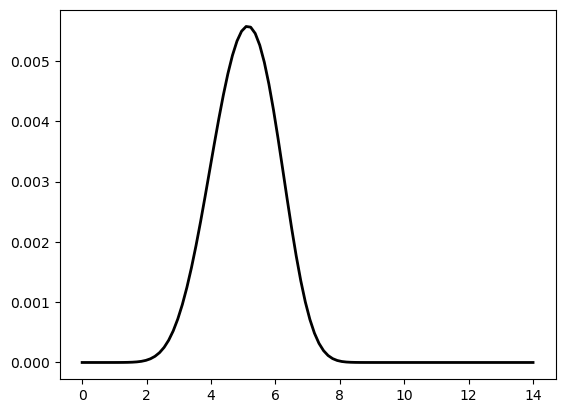

In [257]:
# Plot the histogram of the data
%matplotlib inline


#dist_pts = np.linspace(1, len(p_vals)-1, len(p_vals)-1)

dist_pts = np.linspace(0,cutoff, 100)
plt.plot(dist_pts, guess_fun(dist_pts, m0_GMM, m1_GMM, m2_GMM, m3_GMM, m4_GMM, cutoff),
         linewidth=2, color='k');


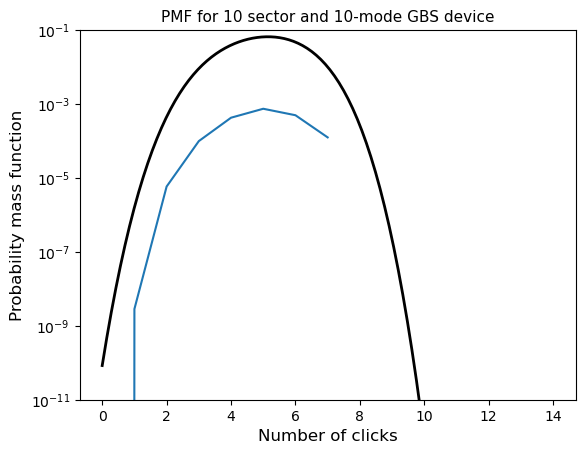

In [259]:
norm = 6.032828581420843#*60

plt.plot(
        range(len(p_vals)),
        p_vals,
        '-' )
plt.plot(dist_pts, guess_fun(dist_pts, m2_GMM, m1_GMM, m2_GMM, m3_GMM, m4_GMM, cutoff)/norm,
         linewidth=2, color='k')
plt.yscale('log')
plt.ylim(10**(-11), 10**(-1))
plt.xlabel("Number of clicks", fontsize=12)
plt.ylabel("Probability mass function", fontsize=12)
plt.title("PMF for 10 sector and 10-mode GBS device", fontsize=11);